In [1]:
!pip install torch

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training EAM Intent Classifier
Epoch 1/50, Loss: 1.9762, Accuracy: 0.4106
Epoch 2/50, Loss: 1.7879, Accuracy: 0.4605
Epoch 3/50, Loss: 1.7450, Accuracy: 0.4615
Epoch 4/50, Loss: 1.6990, Accuracy: 0.4706
Epoch 5/50, Loss: 1.6367, Accuracy: 0.4891
Epoch 6/50, Loss: 1.5548, Accuracy: 0.5141
Epoch 7/50, Loss: 1.4635, Accuracy: 0.5476
Epoch 8/50, Loss: 1.3680, Accuracy: 0.5898
Epoch 9/50, Loss: 1.2733, Accuracy: 0.6286
Epoch 10/50, Loss: 1.1807, Accuracy: 0.6619
Epoch 11/50, Loss: 1.0909, Accuracy: 0.6995
Epoch 12/50, Loss: 1.0073, Accuracy: 0.7212
Epoch 13/50, Loss: 0.9280, Accuracy: 0.7432
Epoch 14/50, Loss: 0.8561, Accuracy: 0.7637
Epoch 15/50, Loss: 0.7873, Accuracy: 0.7823
Epoch 16/50, Loss: 0.7237, Accuracy: 0.8032
Epoch 17/50, Loss: 0.6662, Accuracy: 0.8254
Epoch 18/50, Loss: 0.6122, Accuracy: 0.8403
Epoch 19/50, Loss: 0.5624, Accuracy: 0.8537
Epoch 20/50, Loss: 0.5149, Accuracy: 0.8676
Epoch 21/50, Loss: 0.4723, Accuracy: 0.8819
Epoch 22/50, Loss: 0.4326, Accuracy: 0.8959
Epoch 23/5

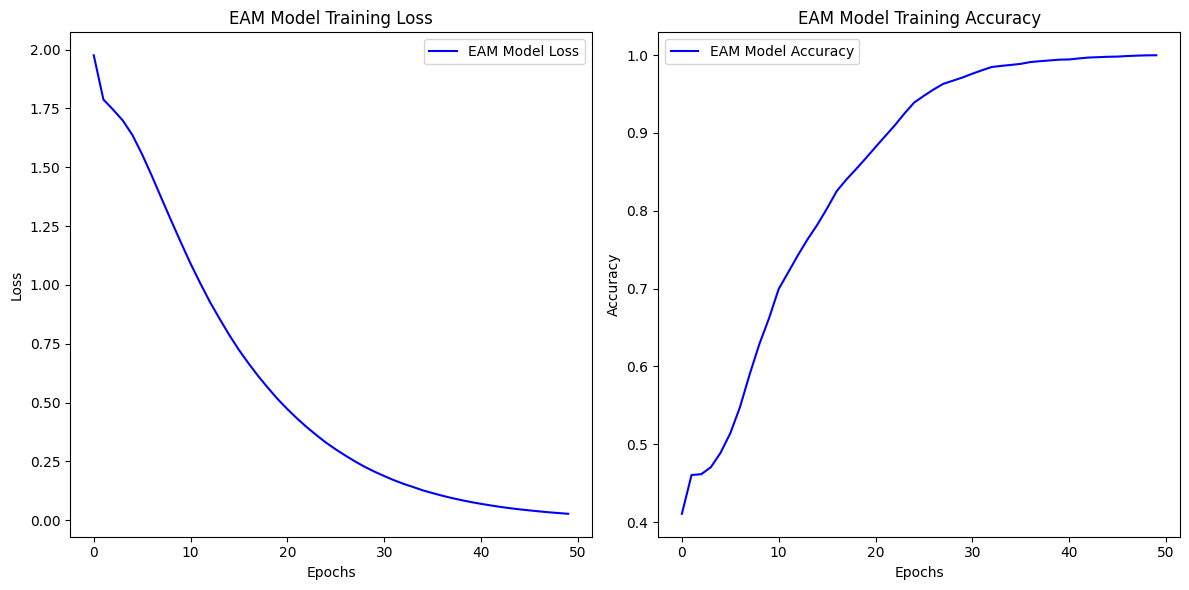

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import time

# TokenPooling class
class TokenPooling(nn.Module):
    def __init__(self, pool_factor=2):
        super(TokenPooling, self).__init__()
        self.pool_factor = pool_factor

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        pooled_seq_len = seq_len // self.pool_factor
        x = x[:, :pooled_seq_len * self.pool_factor, :]
        x = x.view(batch_size, pooled_seq_len, self.pool_factor, embed_dim)
        x = x.mean(dim=2)
        return x

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        return x

# EAM Model for Intent Classification
class EAMIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, pool_factor=1):
        super(EAMIntentClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.token_pooling = TokenPooling(pool_factor)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # (seq_len, batch_size, embed_dim)
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        x = self.token_pooling(x)
        x = self.fc_out(x.mean(dim=1))  # Global average pooling
        return x

# Dataset preparation
class IntentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.texts = df['Description'].values
        self.labels = df['Category'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenization
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load data from CSV
train_df = pd.read_csv("/content/train.csv")
valid_df = pd.read_csv("/content/vald.csv")
test_df = pd.read_csv("/content/test.csv")

# Create a mapping from text labels to numerical labels
label_mapping = {label: idx for idx, label in enumerate(train_df['Category'].unique())}

# Apply the mapping to all datasets
train_df['Category'] = train_df['Category'].map(label_mapping)
valid_df['Category'] = valid_df['Category'].map(label_mapping)
test_df['Category'] = test_df['Category'].map(label_mapping)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create dataset and DataLoader
max_len = 64
train_dataset = IntentDataset(train_df, tokenizer, max_len)
valid_dataset = IntentDataset(valid_df, tokenizer, max_len)
test_dataset = IntentDataset(test_df, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Training function
def train_model(model, dataloader, criterion, optimizer, epochs, device):
    model.to(device)
    train_losses = []
    all_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in dataloader:
            texts_batch, labels_batch = batch['input_ids'].to(device), batch['label'].to(device)
            optimizer.zero_grad()

            outputs = model(texts_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        train_losses.append(avg_loss)
        all_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, all_accuracies

# Initialize the model
vocab_size = tokenizer.vocab_size
embed_dim = 16
num_heads = 2
num_classes = len(train_df['Category'].unique())

eam_model = EAMIntentClassifier(vocab_size=vocab_size, embed_dim=embed_dim, num_heads=num_heads, num_classes=num_classes, pool_factor=2)
optimizer_eam = optim.Adam(eam_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the EAM model
print("Training EAM Intent Classifier")
eam_losses, eam_accuracies = train_model(eam_model, train_loader, criterion, optimizer_eam, epochs=50, device=device)

# Plot Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot Loss over Epochs
plt.subplot(1, 2, 1)
plt.plot(eam_losses, label="EAM Model Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("EAM Model Training Loss")
plt.legend()

# Plot Accuracy over Epochs
plt.subplot(1, 2, 2)
plt.plot(eam_accuracies, label="EAM Model Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("EAM Model Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
!pip install scikit-learn


# **EAM MODEL**

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training EAM Intent Classifier
Epoch 1/60, Loss: 1.9610, Accuracy: 0.4259, Precision: 0.2120, Recall: 0.4259, F1: 0.2830, Memory: 1536233984.00 MB, Time: 2.48 sec
Epoch 2/60, Loss: 1.8056, Accuracy: 0.4600, Precision: 0.2116, Recall: 0.4600, F1: 0.2899, Memory: 1536233984.00 MB, Time: 2.49 sec
Epoch 3/60, Loss: 1.7788, Accuracy: 0.4600, Precision: 0.2116, Recall: 0.4600, F1: 0.2899, Memory: 1536233984.00 MB, Time: 3.15 sec
Epoch 4/60, Loss: 1.7429, Accuracy: 0.4600, Precision: 0.2119, Recall: 0.4600, F1: 0.2901, Memory: 1536233984.00 MB, Time: 2.70 sec
Epoch 5/60, Loss: 1.6979, Accuracy: 0.4638, Precision: 0.4130, Recall: 0.4638, F1: 0.2993, Memory: 1536233984.00 MB, Time: 2.44 sec
Epoch 6/60, Loss: 1.6360, Accuracy: 0.4723, Precision: 0.3991, Recall: 0.4723, F1: 0.3177, Memory: 1536233984.00 MB, Time: 2.42 sec
Epoch 7/60, Loss: 1.5627, Accuracy: 0.4937, Precision: 0.4737, Recall: 0.4937, F1: 0.3591, Memory: 1536233984.00 MB, Time: 2.44 sec
Epoch 8/60, Loss: 1.4769, Accuracy: 0.5154, P

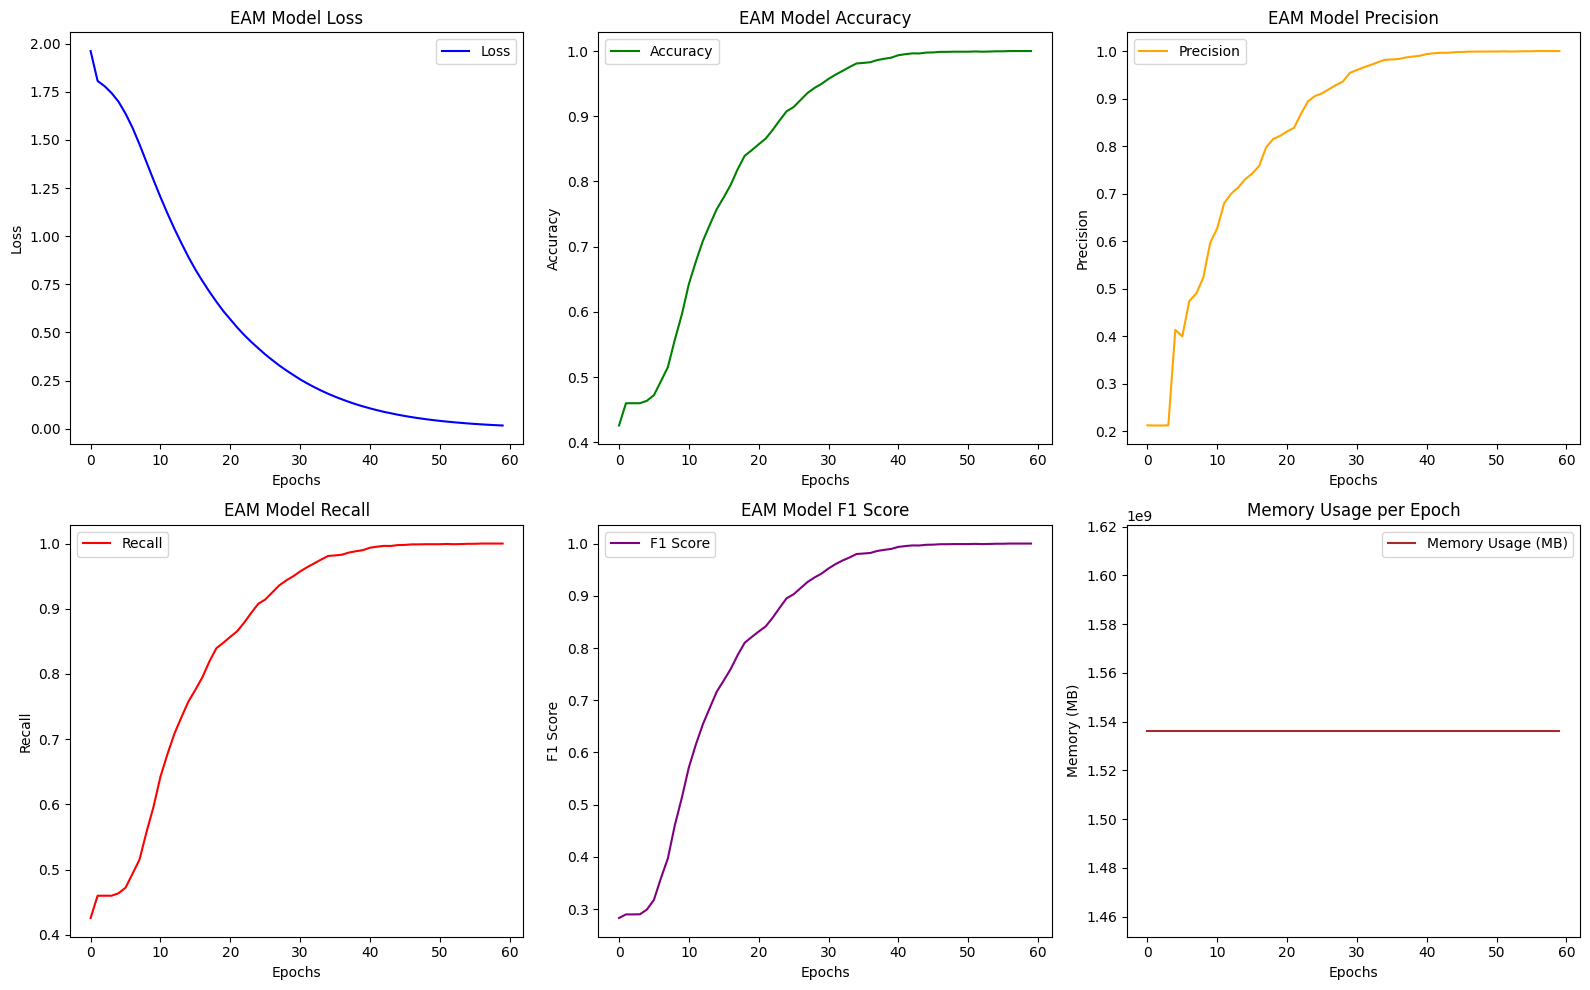

Total training time: 160.75 seconds


In [12]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import precision_score, recall_score, f1_score
import psutil


# TokenPooling class
class TokenPooling(nn.Module):
    def __init__(self, pool_factor=2):
        super(TokenPooling, self).__init__()
        self.pool_factor = pool_factor

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()
        pooled_seq_len = seq_len // self.pool_factor
        x = x[:, :pooled_seq_len * self.pool_factor, :]
        x = x.view(batch_size, pooled_seq_len, self.pool_factor, embed_dim)
        x = x.mean(dim=2)
        return x

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        return x

# EAM Model for Intent Classification
class EAMIntentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes, pool_factor=1):
        super(EAMIntentClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.token_pooling = TokenPooling(pool_factor)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x, attention_mask=None):
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # (seq_len, batch_size, embed_dim)
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # (batch_size, seq_len, embed_dim)
        x = self.token_pooling(x)
        x = self.fc_out(x.mean(dim=1))  # Global average pooling
        return x

# Dataset preparation
class IntentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.texts = df['Description'].values
        self.labels = df['Category'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenization
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load data from CSV
train_df = pd.read_csv("/content/train.csv")
valid_df = pd.read_csv("/content/vald.csv")
test_df = pd.read_csv("/content/test.csv")

# Create a mapping from text labels to numerical labels
label_mapping = {label: idx for idx, label in enumerate(train_df['Category'].unique())}

# Apply the mapping to all datasets
train_df['Category'] = train_df['Category'].map(label_mapping)
valid_df['Category'] = valid_df['Category'].map(label_mapping)
test_df['Category'] = test_df['Category'].map(label_mapping)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create dataset and DataLoader
max_len = 64
train_dataset = IntentDataset(train_df, tokenizer, max_len)
valid_dataset = IntentDataset(valid_df, tokenizer, max_len)
test_dataset = IntentDataset(test_df, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


# Updated Training function
def train_model(model, dataloader, criterion, optimizer, epochs, device):
    model.to(device)
    train_losses = []
    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_f1_scores = []
    memory_usage = []
    training_time = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        all_labels = []
        all_predictions = []

        epoch_start_time = time.time()  # Start timing the epoch

        for batch in dataloader:
            texts_batch, labels_batch = batch['input_ids'].to(device), batch['label'].to(device)
            optimizer.zero_grad()

            outputs = model(texts_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

            # Store predictions and labels for precision, recall, and F1 score calculations
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples
        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

        epoch_end_time = time.time()  # End timing the epoch
        epoch_duration = epoch_end_time - epoch_start_time
        training_time.append(epoch_duration)

        # Track memory usage (GPU memory or system memory based on available hardware)
        if torch.cuda.is_available():
            memory = torch.cuda.memory_allocated(device)
        else:
            memory = psutil.virtual_memory().used / (1024 ** 2)  # Convert bytes to MB
        memory_usage.append(memory)

        # Append metrics
        train_losses.append(avg_loss)
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1_scores.append(f1)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, "
              f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, "
              f"Memory: {memory:.2f} MB, Time: {epoch_duration:.2f} sec")

    return train_losses, all_accuracies, all_precisions, all_recalls, all_f1_scores, memory_usage, training_time

# Initialize the model
vocab_size = tokenizer.vocab_size
embed_dim = 16
num_heads = 2
num_classes = len(train_df['Category'].unique())

eam_model = EAMIntentClassifier(vocab_size=vocab_size, embed_dim=embed_dim, num_heads=num_heads, num_classes=num_classes, pool_factor=2)
optimizer_eam = optim.Adam(eam_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the EAM model
print("Training EAM Intent Classifier")
eam_losses, eam_accuracies, eam_precisions, eam_recalls, eam_f1_scores, memory_usage, training_time = train_model(
    eam_model, train_loader, criterion, optimizer_eam, epochs=60, device=device
)

# Plot Loss, Accuracy, Precision, Recall, F1 Score, Memory Usage, and Training Time
plt.figure(figsize=(16, 10))

# Plot Loss over Epochs
plt.subplot(2, 3, 1)
plt.plot(eam_losses, label="Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("EAM Model Loss")
plt.legend()

# Plot Accuracy over Epochs
plt.subplot(2, 3, 2)
plt.plot(eam_accuracies, label="Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("EAM Model Accuracy")
plt.legend()

# Plot Precision over Epochs
plt.subplot(2, 3, 3)
plt.plot(eam_precisions, label="Precision", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("EAM Model Precision")
plt.legend()

# Plot Recall over Epochs
plt.subplot(2, 3, 4)
plt.plot(eam_recalls, label="Recall", color="red")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("EAM Model Recall")
plt.legend()

# Plot F1 Score over Epochs
plt.subplot(2, 3, 5)
plt.plot(eam_f1_scores, label="F1 Score", color="purple")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("EAM Model F1 Score")
plt.legend()

# Plot Memory Usage over Epochs
plt.subplot(2, 3, 6)
plt.plot(memory_usage, label="Memory Usage (MB)", color="brown")
plt.xlabel("Epochs")
plt.ylabel("Memory (MB)")
plt.title("Memory Usage per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Print total training time
total_training_time = sum(training_time)
print(f"Total training time: {total_training_time:.2f} seconds")


# **TRANSFOMERS MODEL BERT**

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.073200,0.021229,0.995701,0.995745,0.995701,0.995637
2,0.001200,0.000756,1.000000,1.000000,1.000000,1.000000
3,0.000600,0.000466,1.000000,1.000000,1.000000,1.000000
4,0.000500,0.000399,1.000000,1.000000,1.000000,1.000000


Training Time: 809.12 seconds
Memory Consumed: 0.49 GB
Eval Loss: 0.00039856007788330317
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


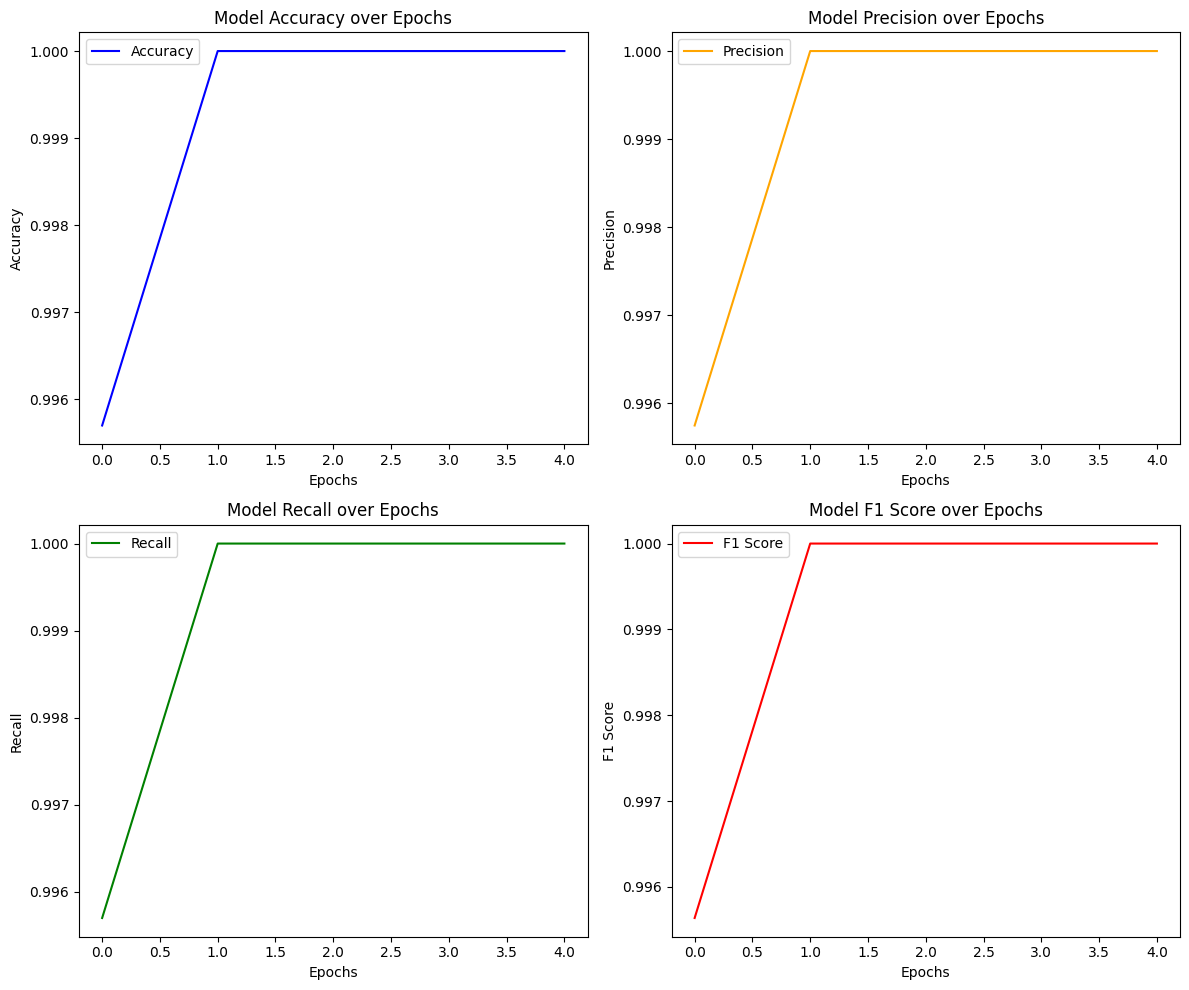

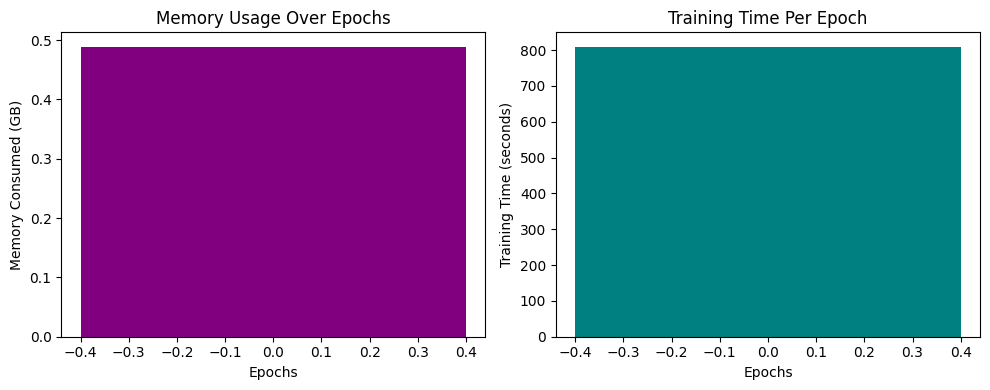

In [8]:
import torch
import time
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
import psutil
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/PROMISE_exp1.csv')

# Preprocessing: convert categories to numerical labels
df['label'] = df['Category'].astype('category').cat.codes
df = df[['Description', 'label']]

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Description'], df['label'], test_size=0.2)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['label'].unique()))

# Metrics logging
training_time = []
memory_consumed = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Define metrics function
def compute_metrics(p):
    preds = torch.tensor(p.predictions)  # Convert predictions to PyTorch tensor
    preds = torch.argmax(preds, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)

    # Log the metrics during training
    accuracy_values.append(acc)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",   # Evaluate after every epoch
    save_strategy="epoch",         # Save model after each epoch
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True    # Load best model at the end of training
)

# Track memory usage before training
initial_memory = psutil.virtual_memory().used / (1024 ** 3)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train model and track time
start_time = time.time()
trainer.train()
end_time = time.time()

# Calculate memory usage and training time
final_memory = psutil.virtual_memory().used / (1024 ** 3)
memory_consumed.append(final_memory - initial_memory)
training_time.append(end_time - start_time)

# Evaluate the model
eval_result = trainer.evaluate()

# Print results
print(f"Training Time: {training_time[-1]:.2f} seconds")
print(f"Memory Consumed: {memory_consumed[-1]:.2f} GB")
print(f"Eval Loss: {eval_result['eval_loss']}")
print(f"Accuracy: {eval_result['eval_accuracy']}")
print(f"Precision: {eval_result['eval_precision']}")
print(f"Recall: {eval_result['eval_recall']}")
print(f"F1 Score: {eval_result['eval_f1']}")

# Plotting the metrics

# Create a figure for subplots
plt.figure(figsize=(12, 10))

# Plot Accuracy over Epochs
plt.subplot(2, 2, 1)
plt.plot(accuracy_values, label="Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy over Epochs")
plt.legend()

# Plot Precision over Epochs
plt.subplot(2, 2, 2)
plt.plot(precision_values, label="Precision", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Model Precision over Epochs")
plt.legend()

# Plot Recall over Epochs
plt.subplot(2, 2, 3)
plt.plot(recall_values, label="Recall", color="green")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Model Recall over Epochs")
plt.legend()

# Plot F1 Score over Epochs
plt.subplot(2, 2, 4)
plt.plot(f1_values, label="F1 Score", color="red")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Model F1 Score over Epochs")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Plot Memory usage and Training Time
plt.figure(figsize=(10, 4))

# Plot Memory Consumption
plt.subplot(1, 2, 1)
plt.bar(range(len(memory_consumed)), memory_consumed, color='purple')
plt.xlabel("Epochs")
plt.ylabel("Memory Consumed (GB)")
plt.title("Memory Usage Over Epochs")

# Plot Training Time
plt.subplot(1, 2, 2)
plt.bar(range(len(training_time)), training_time, color='teal')
plt.xlabel("Epochs")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Per Epoch")

plt.tight_layout()
plt.show()


In [7]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00


# **ROBERT_BASE**

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.051800,0.030242,0.994841,0.994865,0.994841,0.994804
2,0.044100,0.008290,0.998280,0.998287,0.998280,0.998248
3,0.000400,0.000247,1.000000,1.000000,1.000000,1.000000
4,0.000300,0.000209,1.000000,1.000000,1.000000,1.000000


Training Time: 901.16 seconds
Memory Consumed: -0.02 GB
Eval Loss: 0.0002085596352117136
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


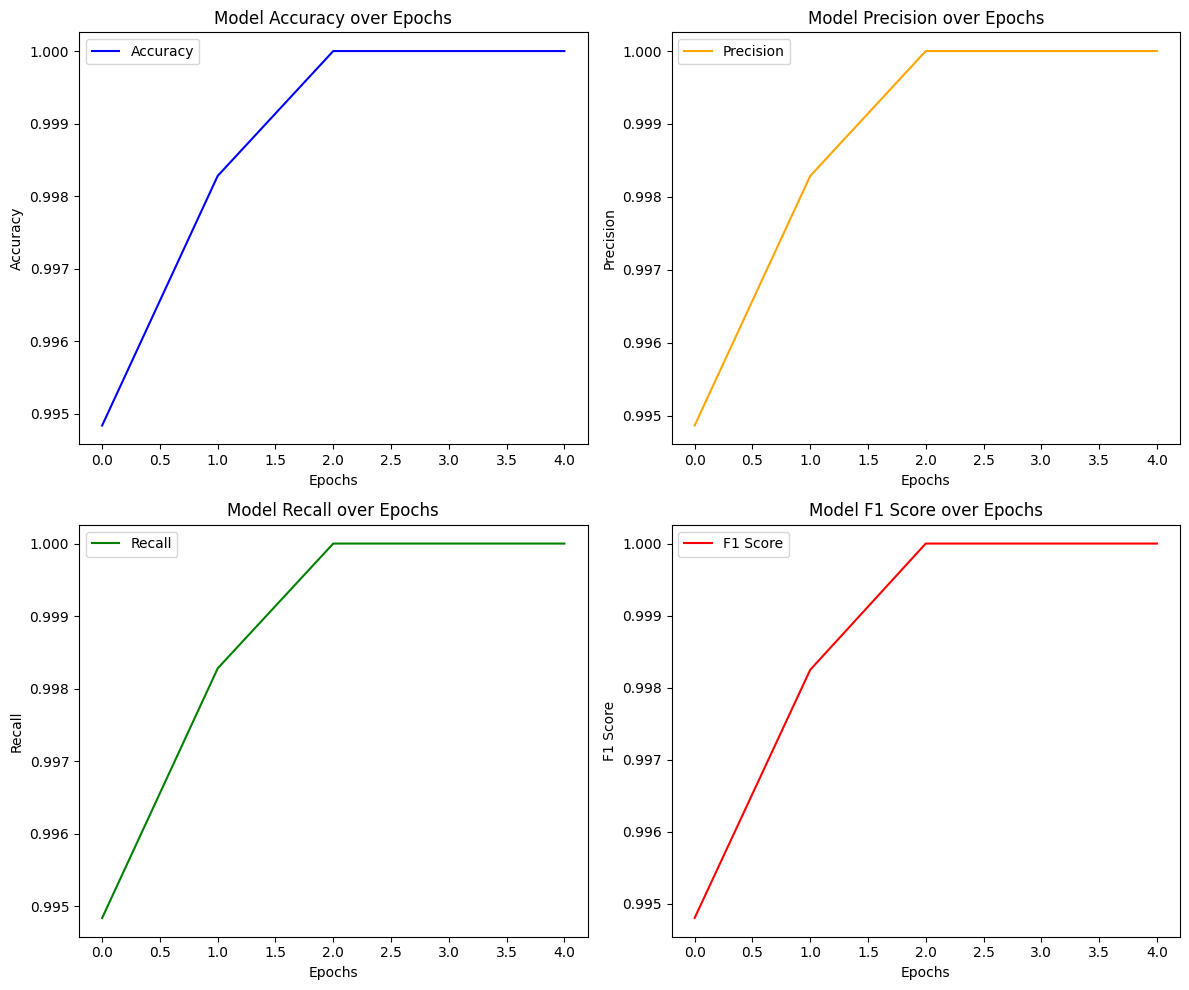

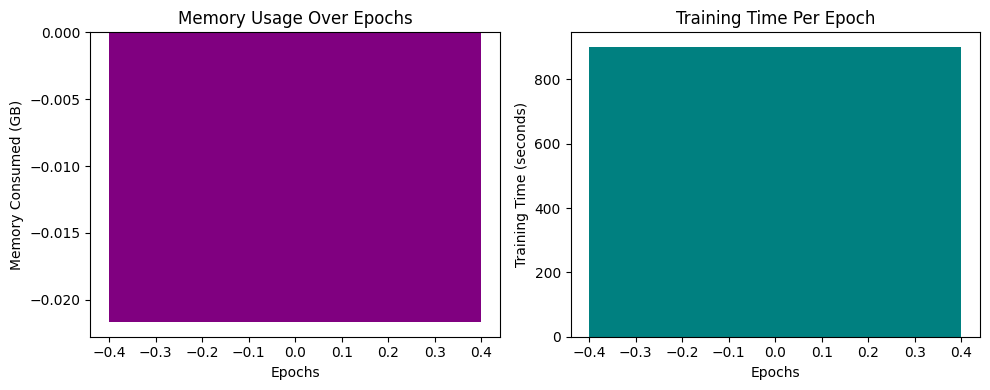

In [10]:
import torch
import time
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
import psutil
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/PROMISE_exp1.csv')

# Preprocessing: convert categories to numerical labels
df['label'] = df['Category'].astype('category').cat.codes
df = df[['Description', 'label']]

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Description'], df['label'], test_size=0.2)

# Tokenization using RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})

# Load pre-trained RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(df['label'].unique()))

# Metrics logging
training_time = []
memory_consumed = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Define metrics function
def compute_metrics(p):
    preds = torch.tensor(p.predictions)  # Convert predictions to PyTorch tensor
    preds = torch.argmax(preds, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)

    # Log the metrics during training
    accuracy_values.append(acc)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",   # Evaluate after every epoch
    save_strategy="epoch",         # Save model after each epoch
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True    # Load best model at the end of training
)

# Track memory usage before training
initial_memory = psutil.virtual_memory().used / (1024 ** 3)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train model and track time
start_time = time.time()
trainer.train()
end_time = time.time()

# Calculate memory usage and training time
final_memory = psutil.virtual_memory().used / (1024 ** 3)
memory_consumed.append(final_memory - initial_memory)
training_time.append(end_time - start_time)

# Evaluate the model
eval_result = trainer.evaluate()

# Print results
print(f"Training Time: {training_time[-1]:.2f} seconds")
print(f"Memory Consumed: {memory_consumed[-1]:.2f} GB")
print(f"Eval Loss: {eval_result['eval_loss']}")
print(f"Accuracy: {eval_result['eval_accuracy']}")
print(f"Precision: {eval_result['eval_precision']}")
print(f"Recall: {eval_result['eval_recall']}")
print(f"F1 Score: {eval_result['eval_f1']}")

# Plotting the metrics

# Create a figure for subplots
plt.figure(figsize=(12, 10))

# Plot Accuracy over Epochs
plt.subplot(2, 2, 1)
plt.plot(accuracy_values, label="Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy over Epochs")
plt.legend()

# Plot Precision over Epochs
plt.subplot(2, 2, 2)
plt.plot(precision_values, label="Precision", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Model Precision over Epochs")
plt.legend()

# Plot Recall over Epochs
plt.subplot(2, 2, 3)
plt.plot(recall_values, label="Recall", color="green")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Model Recall over Epochs")
plt.legend()

# Plot F1 Score over Epochs
plt.subplot(2, 2, 4)
plt.plot(f1_values, label="F1 Score", color="red")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Model F1 Score over Epochs")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Plot Memory usage and Training Time
plt.figure(figsize=(10, 4))

# Plot Memory Consumption
plt.subplot(1, 2, 1)
plt.bar(range(len(memory_consumed)), memory_consumed, color='purple')
plt.xlabel("Epochs")
plt.ylabel("Memory Consumed (GB)")
plt.title("Memory Usage Over Epochs")

# Plot Training Time
plt.subplot(1, 2, 2)
plt.bar(range(len(training_time)), training_time, color='teal')
plt.xlabel("Epochs")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Per Epoch")

plt.tight_layout()
plt.show()


# **distilbert-base-uncased**

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.027100,0.003116,1.000000,1.000000,1.000000,1.000000
2,0.000800,0.000463,1.000000,1.000000,1.000000,1.000000
3,0.000600,0.000262,1.000000,1.000000,1.000000,1.000000
4,0.000300,0.000217,1.000000,1.000000,1.000000,1.000000


Training Time: 429.01 seconds
Memory Consumed: -0.02 GB
Eval Loss: 0.0002169673389289528
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


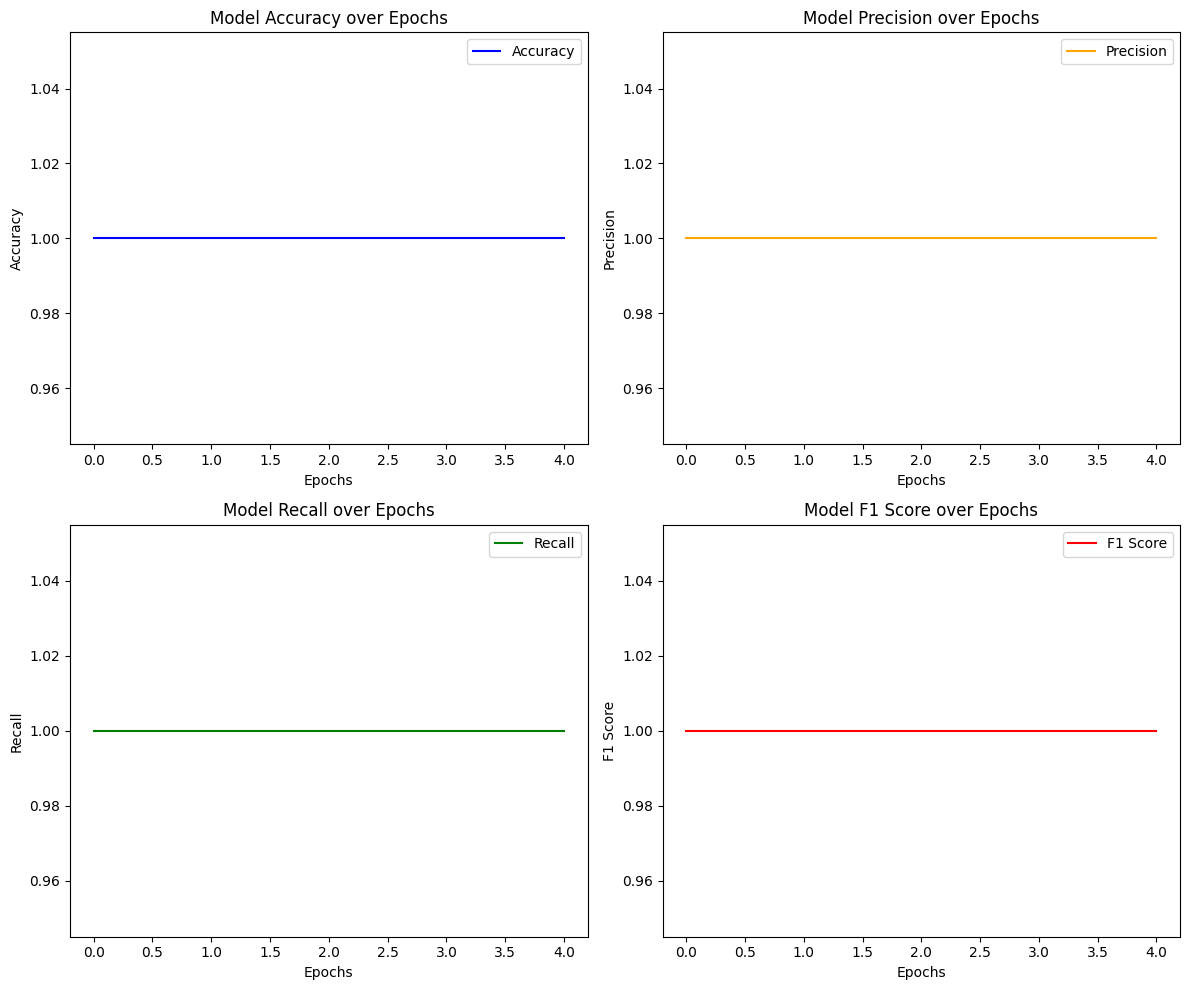

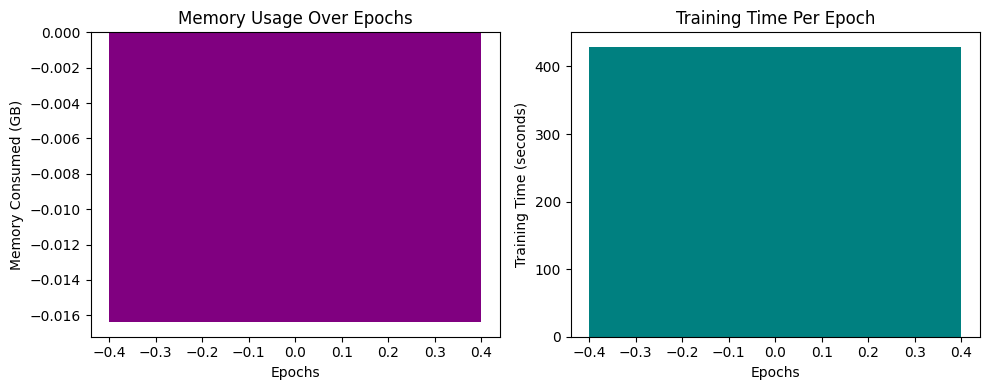

In [13]:
import torch
import time
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
import psutil
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/PROMISE_exp1.csv')

# Preprocessing: convert categories to numerical labels
df['label'] = df['Category'].astype('category').cat.codes
df = df[['Description', 'label']]

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Description'], df['label'], test_size=0.2)

# Tokenization using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

# Convert to Hugging Face datasets
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})

# Load pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df['label'].unique()))

# Metrics logging
training_time = []
memory_consumed = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Define metrics function
def compute_metrics(p):
    preds = torch.tensor(p.predictions)  # Convert predictions to PyTorch tensor
    preds = torch.argmax(preds, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)

    # Log the metrics during training
    accuracy_values.append(acc)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",   # Evaluate after every epoch
    save_strategy="epoch",         # Save model after each epoch
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True    # Load best model at the end of training
)

# Track memory usage before training
initial_memory = psutil.virtual_memory().used / (1024 ** 3)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train model and track time
start_time = time.time()
trainer.train()
end_time = time.time()

# Calculate memory usage and training time
final_memory = psutil.virtual_memory().used / (1024 ** 3)
memory_consumed.append(final_memory - initial_memory)
training_time.append(end_time - start_time)

# Evaluate the model
eval_result = trainer.evaluate()

# Print results
print(f"Training Time: {training_time[-1]:.2f} seconds")
print(f"Memory Consumed: {memory_consumed[-1]:.2f} GB")
print(f"Eval Loss: {eval_result['eval_loss']}")
print(f"Accuracy: {eval_result['eval_accuracy']}")
print(f"Precision: {eval_result['eval_precision']}")
print(f"Recall: {eval_result['eval_recall']}")
print(f"F1 Score: {eval_result['eval_f1']}")

# Plotting the metrics

# Create a figure for subplots
plt.figure(figsize=(12, 10))

# Plot Accuracy over Epochs
plt.subplot(2, 2, 1)
plt.plot(accuracy_values, label="Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy over Epochs")
plt.legend()

# Plot Precision over Epochs
plt.subplot(2, 2, 2)
plt.plot(precision_values, label="Precision", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Model Precision over Epochs")
plt.legend()

# Plot Recall over Epochs
plt.subplot(2, 2, 3)
plt.plot(recall_values, label="Recall", color="green")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Model Recall over Epochs")
plt.legend()

# Plot F1 Score over Epochs
plt.subplot(2, 2, 4)
plt.plot(f1_values, label="F1 Score", color="red")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Model F1 Score over Epochs")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Plot Memory usage and Training Time
plt.figure(figsize=(10, 4))

# Plot Memory Consumption
plt.subplot(1, 2, 1)
plt.bar(range(len(memory_consumed)), memory_consumed, color='purple')
plt.xlabel("Epochs")
plt.ylabel("Memory Consumed (GB)")
plt.title("Memory Usage Over Epochs")

# Plot Training Time
plt.subplot(1, 2, 2)
plt.bar(range(len(training_time)), training_time, color='teal')
plt.xlabel("Epochs")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Per Epoch")

plt.tight_layout()
plt.show()
